# Load data, import modules

In [2]:
# load data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
np.random.seed(69)
import statistics
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *


# import data, drop unnecessary years, and set variable types
df = pd.read_csv('drill_costs.csv')
df = df[(df['date'] > 1990) & (df['date'] != 2007)]
df = df.reset_index(drop=True)
df['avg_dx_oil_gas_well'] = df['avg_dx_oil_gas_well'].astype(float)
df['dx_gas'] = df['dx_gas'].astype(float)
df['dx_oil'] = df['dx_oil'].astype(float)
df['dx_well'] = df['dx_well'].astype(float)
df_cost = df

df_price = pd.read_csv('oil_price_projections.csv')
df_price = df_price[(df_price['year'] <= 2035) & (df_price['year'] != 2020)]
df_price = df_price.reset_index(drop=True)

# KDE for 2020 Drill Costs

In [3]:
# function for generating kde
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kde_sample(x, x_grid, n, bandwidth=.02):
    """return random sample from KDE"""
    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(x[:, np.newaxis])
    sample = kde_skl.sample(n_samples = n)
    return(sample)

In [4]:
def drill_cost_sim(sim_size, bandwidth = .0521, 
               t_min1 = -.22, t_mean1 = -.0917, t_max1 = -.07,
               t_min2 = .02, t_mean2 = .05, t_max2 = .06):
    '''Simulate distribution of drilling costs for 2020 using the KDE for 2008-2012.'''

    from sklearn.neighbors import KernelDensity
    from scipy.stats import gaussian_kde
        
    sim_size = sim_size*2
    
    # average cost for 2006
    cost_t0 = np.mean(
    df[['oil_k','gas_k', 'well_k']][df['date'] == 2006].values)

    # input variables
    ls = [df['dx_gas'], df['dx_oil'], df['dx_well']]
    x = [item for sublist in ls for item in sublist] # get all columns values into a flat list
        
    # for kde sampling    
    x_d = np.linspace(-.5, .5, 100000)  
    x = np.array(x) 
    
    # 2007
    dx = kde_sample(x, x_d, n = sim_size, bandwidth=bandwidth)
    cost_t = cost_t0*(1+dx)
    
    for i in range(2008,2013):            
        dx = kde_sample(x, x_d, n = sim_size, bandwidth = bandwidth)
        cost_t = cost_t*(1+dx)
    
    for i in range(2013, 2016):
        dx = np.random.triangular(left = t_min1, mode = t_mean1, right = t_max1, size = sim_size)
        dx = np.array([[item] for item in dx])
        cost_t = cost_t*(1+dx) 
        
    for i in range(2016, 2021):
        dx = np.random.triangular(left = t_min2, mode = t_mean2, right = t_max2, size = sim_size)
        dx = np.array([[item] for item in dx])
        cost_t = cost_t*(1+dx) 
    
    return(list(cost_t.flatten()))

In [5]:
def get_drill_cost_vec(kde_values, sim_size):
    '''Draw a sample from the KDE to be used as the drilling cost.'''
    
    import random
    samp = random.sample(kde_values, k = sim_size)
    samp = np.array(samp)
    samp = samp.flatten()
    
    return(samp)

# Dry Well Simulation

In [6]:
def sim_dry_vec(sim_size):
    drill_cost_dist = drill_cost_sim(sim_size)
    drill_cost_dist = list(drill_cost_dist)
    
    # unit costs
    cost_per_acre = 960
    cost_per_section = 43000
    
    # simulate (overhead will need to be added for future years as well)
    n_acres = np.random.normal(600, 60, size = sim_size) 
    n_sections = np.random.normal(3, .35, size = sim_size) 
    overhead = np.random.triangular(left = 172000, mode = 215000, right = 279500, size = sim_size)
    
    # sample from the KDE distribution and use this as the drilling cost
    cost_drilling = get_drill_cost_vec(drill_cost_dist, sim_size) * 1000 # multiply by 1000 since these numbers are in thousands of dollars
    
    total_cost_acre = cost_per_acre * n_acres
    total_cost_section = cost_per_section * n_sections
        
    final_cost = (total_cost_acre + total_cost_section + overhead + cost_drilling)
        
    return(final_cost)

# Wet Well Simulation

In [7]:
def initial_cost_vec(kde_values, sim_size):
    '''Return overhead cost to be used for the years 2021-2035, as well as the year 0 fixed costs'''
    # year 0 costs
    
    # unit costs
    cost_per_acre = 960
    cost_per_section = 43000
    
    # simulate (overhead will need to be added for future years as well)
    n_acres = np.random.normal(600, 50, size = sim_size) 
    n_sections = np.random.normal(3, .35, size = sim_size) 
    overhead = np.random.triangular(left = 172000, mode = 215000, right = 279500, size = sim_size)
    cost_completion = np.random.normal(390000, 50000, size = sim_size)
    
    # sample from the KDE distribution and use this as the drilling cost
    cost_drilling = get_drill_cost_vec(kde_values, sim_size) * 1000 # multiply by 1000 since these numbers are in thousands of dollars
    
    total_cost_acre = cost_per_acre * n_acres
    total_cost_section = cost_per_section * n_sections
        
    final_cost = (total_cost_acre + total_cost_section + overhead + cost_drilling + cost_completion)
        
    return(overhead, final_cost)

def get_rates_vec(sim_size):
    '''Returns the population of correlated initial production rates and decline rates.'''
    
    # functions and matrices for chol decomp later
    def standardize(x):
        x_std = (x - x.mean())/x.std()
        return(x_std)

    def destandardize(x_std, x):
        x_old = (x_std * x.std()) + x.mean()
        return(x_old)
    
    r = np.array([[1, .64], [.64, 1]]) # correlation matrix
    u = np.linalg.cholesky(r)
    
    init_rate = np.random.lognormal(6, .28, size = sim_size) # barrels/day

    # decline rate
    dec_rate = np.random.uniform(.15, .32, size = sim_size)

    # make init_rate and dec_rate correlated (.64)
    both_rates = [standardize(dec_rate), standardize(init_rate)]
    id_rate = np.dot(u, both_rates).T

    final_id_rate = np.array([[destandardize(id_rate[:, 0], dec_rate)],
                         [destandardize(id_rate[:, 1], init_rate)]])
    final_id_rate = final_id_rate.squeeze()
    
    return(final_id_rate)

def get_price_vec(year, sim_size):
    '''Return the price of oil from the specified year'''
    df_cols = df_price[['high_oil_price', 'low_oil_price', 'ref_oil_price']]
    
    prices = df_cols[df_price['year'] == year].values
    price = np.random.triangular(right = prices[0][0], left = prices[0][1], mode = prices[0][2], size = sim_size)

    price = np.atleast_2d([price])
    
    return(price)

def n_barrels_matrix(sim_size):
    '''Returns a simulated matrix. Number of columns = number of simulations,
    number of rows = number of years (i.e., there will be 15 rows). 
    '''    
    
    # calculate the initial production rate and decline rate
    dec_rate, ip_rate = get_rates_vec(sim_size)
    annual_rate = 365 * ip_rate
    
    avg_prod_lst = []
    
    for j in range(15):
        annual_rate_t0 = annual_rate
        annual_rate = annual_rate*(1-dec_rate)
        
        avg_production = (annual_rate_t0 + annual_rate) / 2
        avg_prod_lst.append(avg_production)
        
    matrix = np.array(avg_prod_lst)
    
    return(matrix)

def get_annual_rev_matrix(sim_size):
    ''' Return matrix of simulated total annual revenue for years 2021-2035
            nrows = number of years
            ncols = number of simulations
    '''
    barrels = n_barrels_matrix(sim_size) # matrix containing oil produced for each year 
    
    rev = []
    
    n = 0
    for i in range(2021, 2036):
        # initial revenue
        price = get_price_vec(i, sim_size) # price for year i
        quantity = barrels[n, :] # quantity for year i 
        revenue = price * quantity
        
        # nri
        nri_rate = np.random.normal(.75, .02, size = sim_size)
        revenue_post_nri = revenue * nri_rate
        
        # tax
        revenue_post_tax = revenue_post_nri*(1-.046)
        
        # operating expenses
        oc_per_barrel = np.random.normal(2.25, .3, size = sim_size)
        annual_oc = oc_per_barrel * quantity
        
        # total revenue 
        total_rev = revenue_post_tax - annual_oc        
        rev.append(total_rev)        
        n += 1
        
    rev = np.array(rev)
    
    return(rev)

def sim_wet_npv_vec(sim_size):
    '''Return vector of simulated NPVs, dimension of vector is [sim_size x 1]'''
    
    kde_values = drill_cost_sim(sim_size)
    
    overhead, initial_c = initial_cost_vec(kde_values, sim_size)
    total_overhead = overhead * 15 # don't need to include in initial_cost, bc that has already been accounted for
    
    fnr = get_annual_rev_matrix(sim_size)
    
    weighted_fnr_total = 0
    n = 0 
    for i in range(1, 16):
        weighted_fnr = fnr[n, :] / (1.1)**i
        weighted_fnr_total += weighted_fnr
        n += 1
        
    npv = np.array(weighted_fnr_total - initial_c - overhead)
    
    return(npv)

# Dry Hole Risk 

## Histograms for hydrocarbons and resevoirs

In [8]:
def prob_Hc(n):
    from scipy.stats import truncnorm, bernoulli
    
    # hydrocarbons (lower, upper = bounds for distribution)
    mean = .99
    std = .05
    lower = (0 - mean) / std
    upper = (1 - mean) / std
    hc_dist = truncnorm(loc = mean, scale = std, a = lower, b = upper)
    hc_prob = hc_dist.rvs(n)
    
    return(hc_prob)

def prob_Res(n):
    from scipy.stats import truncnorm, bernoulli
    
    # resevoir
    mean = .8
    std = .1
    lower = (0 - mean) / std
    upper = (1 - mean) / std
    res_dist = truncnorm(loc = mean, scale = std, a = lower, b = upper)
    res_prob = res_dist.rvs(n)
    
    return(res_prob)

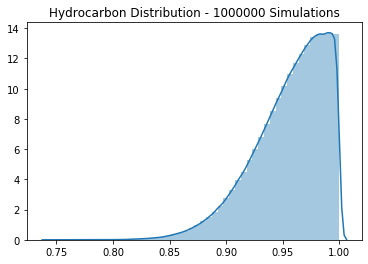

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

sims = 1000000

hc_dist = prob_Hc(sims)
res_dist = prob_Res(sims)

sns.distplot(hc_dist);
plt.title('Hydrocarbon Distribution - {} Simulations'.format(sims)); 

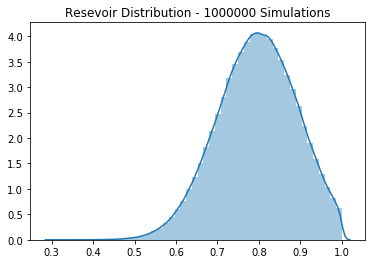

In [10]:
sns.distplot(res_dist);
plt.title('Resevoir Distribution - {} Simulations'.format(sims));

## Simulate proportion of wet wells

In [12]:
def prob_Wet(n):
    '''Returns the probability that a well is wet. Each element of the vector corresponds to the probability
    of one well having oil.'''
    from scipy.stats import truncnorm, bernoulli
    
    # hydrocarbons (lower, upper = bounds for distribution)
    mean = .99
    std = .05
    lower = (0 - mean) / std
    upper = (1 - mean) / std
    hc_dist = truncnorm(loc = mean, scale = std, a = lower, b = upper)
    hc_prob = hc_dist.rvs(n)
    
        
    # resevoir
    mean = .8
    std = .1
    lower = (0 - mean) / std
    upper = (1 - mean) / std
    res_dist = truncnorm(loc = mean, scale = std, a = lower, b = upper)
    res_prob = res_dist.rvs(n)
    
    # product of probabilities is p(well) = wet (resulting shape is (n, )) (i.e., 1-dimensional)
    p_wet = hc_prob * res_prob
    p_wet = np.array(p_wet)
    
    return(p_wet)

In [13]:
def wet(sim_size, output):
    '''Returns distribution of of the specified output parameter.
        output parameter = ["proportion", "n_wet", "wet_dry"]
    '''
    from scipy.stats import truncnorm, bernoulli
    
    # validate output specification 
    if output not in ['proportion', 'n_wet', 'wet_dry']:
        return('Output parameter invalid. Output must be one of ["proportion", "n_wet", "wet_dry"]')
    
    # vector of the number of planned wells (vector of length = sim_size)
    n_planned_wells = np.random.randint(10, 31, sim_size) # for this function, the inputs for the bounds are [a, b).
                                                            # that's why it's 10 to 31 instead of 10 to 30 
    # calculate p(wet) for each well
    wet_lst = []
    dry_lst = []
    
    from tqdm import tqdm 
    for n in tqdm(n_planned_wells):
        # create vector of size n for storing 1s and 0s and then summing the elements for calculating the 
        # number of wells that are actually wet
        
        sample_size = n
        
        # probability that well is wet
        p_wet = prob_Wet(n)
                  
        # create bernouilli distribution with p_wet
        well_dist = bernoulli(p_wet)
        
        # sample from the distribution (values = [0,1])
        wet = well_dist.rvs(n) 
        
        # sum elements of vector to determine number of wet wells
        n_wet = np.sum(wet)
        
        # number of dry wells
        n_dry = n - n_wet
        
        # proportion of wells that are wet (For the given simulation)
        perc_wet = n_wet / n
        
        # conditions for returning the desired output
        if output == 'proportion':
            wet_lst.append(perc_wet)
        
        if output == 'n_wet':
            wet_lst.append(n_wet)
            
        if output == 'wet_dry':
            wet_lst.append(n_wet)
            dry_lst.append(n_dry)
    
    if output in ['proportion', 'n_wet']:
        return(wet_lst) 
    
    else:
        return(wet_lst, dry_lst)

## Histogram of Proportion of Wet Wells

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [57:09<00:00, 291.56it/s]


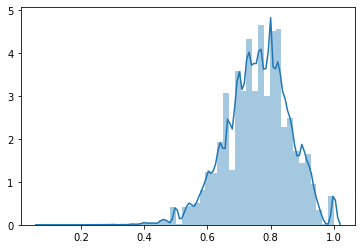

In [14]:
# 1 million simulations

test_proportion = wet(1000000, output = 'proportion')

sns.distplot(test_proportion)

### Using plotnine as a ggplot replacement

C:\Users\Ryan Weisner\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


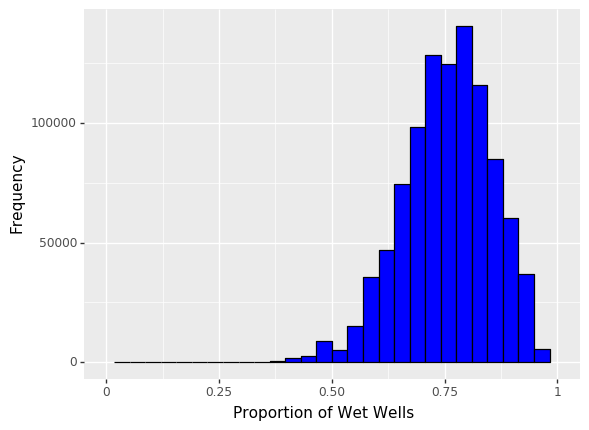

<ggplot: (-9223371842895907872)>

In [38]:
df_prop = pd.DataFrame(test_proportion)
df_prop.columns = ['proportion']

(
    ggplot(data = df_prop, mapping = aes(x = 'proportion'))
    + geom_histogram(bins = 30, fill = 'blue', color = 'black')
    + xlim(0, 1)
    + xlab('Proportion of Wet Wells')
    + ylab('Frequency')
)

In [41]:
df_prop.to_csv('proportion_wet.csv')

## Histogram of the Count of Wet wells

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [54:34<00:00, 305.41it/s]


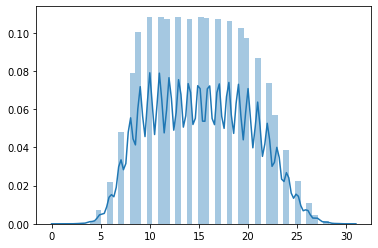

In [15]:
import seaborn as sns

test = wet(1000000, output = 'n_wet') # proportion = false

sns.distplot(test)

C:\Users\Ryan Weisner\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


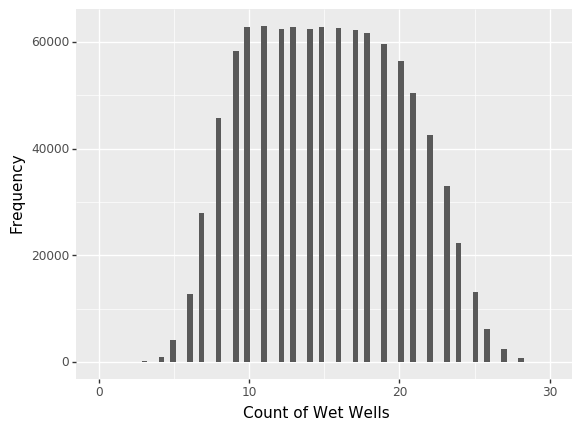

<ggplot: (-9223371842899128476)>

In [22]:
df_test = pd.DataFrame(test)
df_test.columns = ['n_wet']

(
    ggplot(data = df_test, mapping = aes(x = 'n_wet'))
    + geom_histogram(bins = 80)
    + xlim(0, 30)
    + xlab('Count of Wet Wells')
    + ylab('Frequency')
)

# Final Simulation: Distribution of NPV for All Wells

In [16]:
def final_sim(sim_size):
    '''Return final distribution of NPVS by simulating the cost and NPV of dry and wet wells, and then 
    multiplying these by the simulated number of dry and wet wells.'''
    
    # simulate number of wet and dry wells
    n_wet, n_dry = wet(sim_size, output = 'wet_dry')
    
    # cost of dry well
    dry_cost = sim_dry_vec(sim_size)
    
    # NPV of wet well
    wet_npv = sim_wet_npv_vec(sim_size)
    
    # vector of net npvs (each simulation has 1 final npv value)
    net_npv = (n_wet * wet_npv) - (n_dry * dry_cost)
    
    # remove unnecessary dimensions
    net_npv = net_npv.flatten()
    
    return(net_npv)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [50:26<00:00, 330.46it/s]


Quantiles:
-----


,0.01,0.01,0.05,0.25,0.50,0.75,0.95,0.99,0.99
0,19714257.23,32782582.45,71316194.37,143672147.38,215508053.19,309181440.43,484082336.23,641361024.94,707881170.53


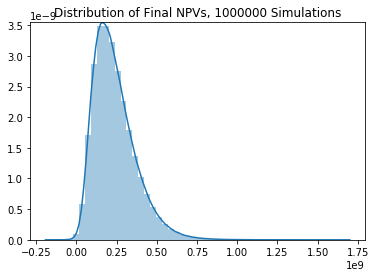

In [17]:
np.set_printoptions(suppress = True, formatter={'float_kind':'{:0.2f}'.format})

sim_size = 1000000
final_vals = final_sim(sim_size)

graph = sns.distplot(final_vals)
graph = plt.title('Distribution of Final NPVs, {} Simulations'.format(sim_size))

print('Quantiles:\n-----')
q = [.005, .01, .05, .25, .5, .75, .95, .99, .995]
pd.DataFrame(np.quantile(final_vals, q), index = q).T

C:\Users\Ryan Weisner\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 20 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\Ryan Weisner\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


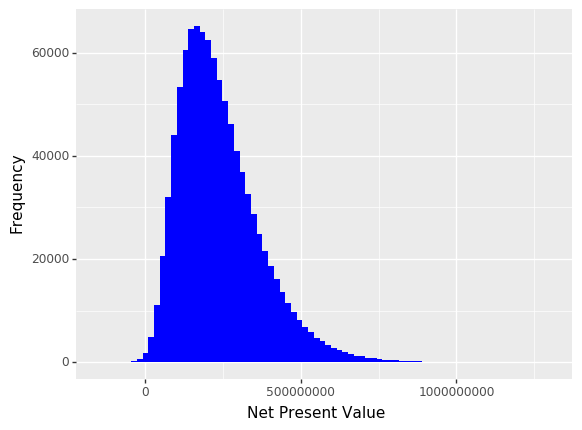

<ggplot: (-9223371842897639208)>

In [29]:
df_net_npv = pd.DataFrame(final_vals)
df_net_npv.columns = ['npv']

(
    ggplot(data = df_net_npv, mapping = aes(x = 'npv'))
    + geom_histogram(bins = 80, fill = 'blue')
    + xlim(-150000000,1300000000)
    + xlab('Net Present Value')
    + ylab('Frequency')
)

In [40]:
df_net_npv.to_csv('net_npv.csv')

## Expected Shortfall

In [42]:
def es(quantiles):
    '''Calculate and return the Expected Shortfall for each quantile specified by the user.
        
    The parameter should be array-like or iterable. 
    '''
    
    es_lst = []
    
    for q in quantiles:
        # number of observations to get for the given quantile
        n = 1000000 * q
        
        top_n = df_net_npv.nsmallest(int(n), 'npv')
        
        es = top_n.mean().values
        
        print(str(q) + ' shortfall: ' + str(es))
        
        es_lst.append(es)
        
    return(es_lst)

In [45]:
q = [.001, .005, .01, .05, .10, .25]

expected_short_fall = es(q)

0.001 shortfall: [-24533640.78]
0.005 shortfall: [2631216.45]
0.01 shortfall: [14769419.24]
0.05 shortfall: [47452412.08]
0.1 shortfall: [65710087.10]
0.25 shortfall: [98692095.18]


In [44]:
pd.DataFrame(expected_short_fall, index = q).T

,0.00,0.01,0.01,0.05,0.10
0,-24533640.78,2631216.45,14769419.24,47452412.08,65710087.10


In [48]:
def er(quantiles):
    '''Calculate and return the Expected Returns for each quantile specified by the user.
        
    The parameter should be array-like or iterable. 
    '''
    
    es_lst = []
    
    for q in quantiles:
        # number of observations to get for the given quantile
        n = 1000000 * q
        
        top_n = df_net_npv.nlargest(int(n), 'npv')
        
        es = top_n.mean().values
        
        print(str(q) + ' average return: ' + str(es))
        
        es_lst.append(es)
        
    return(es_lst)

In [49]:
q = [.001, .005, .01, .05, .10, .25]

expected_returns = er(q)

0.001 average return: [965640674.62]
0.005 average return: [805713558.47]
0.01 average return: [738389330.52]
0.05 average return: [582240085.49]
0.1 average return: [513435481.73]
0.25 average return: [418041593.90]
